In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
scatter_const=10
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score


root_folder = '/content/gdrive/My Drive/deep learning for heat transfer/'

import os
import scipy.io as spio

from matplotlib import pyplot as plt
from matplotlib import colors

    
def initFig(k_num,num_thre,rows=4,cols=4,image_height=4,image_width=5,hspace = 0.3, wspace=0.4):

  fig, axs = plt.subplots(rows,cols, figsize=(cols*image_width, rows*image_height), facecolor='w', edgecolor='k')
  fig.subplots_adjust(hspace, wspace)
  axs = axs.ravel()
  return fig, axs

def readXY(dirData,L,num_par,num):
  
  mat1 = spio.loadmat(dirData, squeeze_me=True)
  record1 = mat1['record'] # array
  maxT1=record1[:,num_par+1]
  X1=record1[:,num:num+L**2]
  
  return X1, maxT1

def readXYseries(dirDatas,L,num_par,num):
  flag=1
  for counter, dirData in enumerate(dirDatas):
    X1,maxT1=readXY(dirData,L,num_par,num)
    if flag:
      geo=X1
      maxT=maxT1
      flag=0
    else:
      geo=np.concatenate((geo,X1),axis=0)
      maxT=np.concatenate((maxT,maxT1),axis=0)
  return geo, maxT

def getTthre(maxT, num_thre,buffer):
  maxInc=np.amax(maxT)
  minInc=np.amin(maxT)
  print("Max Temperature Increase is",str(maxInc))
  print("Min Temperature Increase",str(minInc))
  # visualize the weight

  start=int(math.ceil(minInc / 10.0)) * 10
  end=int(math.floor(maxInc / 10.0)) * 10
  T_thres=np.linspace(start+buffer, end-buffer, num_thre)
  return T_thres

def printStr(T_thre) :
  g = float("{0:.2f}".format(T_thre))
  return str(g)
def plotRank_ax(x,y,titles,ax,size):
  
  im = ax.scatter(x, y, s=size, alpha=0.5)
  ax.set(title=titles)

class MidpointNormalize(colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
  
def print2D_ax(array,L,titles,ax):
  if array.shape[0]==1:
    B=np.reshape(array, (-1, L))
  else:
    B = np.reshape(array[0,:], (-1, L))
  elev_min=np.amin(array[0,:])
  elev_max=np.amax(array[0,:])
  plot_max=max(elev_max,-elev_min)
  mid_val=0
  cmap='bwr' 
  #plt.pcolor(B,cmap=cmap, clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
  im = ax.pcolor(B,cmap=cmap, clim=(-plot_max, plot_max), norm=MidpointNormalize(midpoint=mid_val,vmin=-plot_max, vmax=plot_max))
  ax.figure.colorbar(im, ax=ax)
  ax.set(title=titles)
  




      

In [0]:
def logitClassify_loop_thre_plotCanML(num_can,train_test_set,axs,num,L,T_thre):
    x_train,y_train,x_test,y_test,y_test1=train_test_set
    # all parameters not specified are set to their defaults
    logisticRegr = LogisticRegression(solver='lbfgs')
    logisticRegr.fit(x_train, y_train)
    y_pred2=logisticRegr.predict(x_test)
    
    probas = logisticRegr.predict_proba(x_test)
    order1=probas[:,1].argsort()

    #print(rank1.shape)
    order2=np.argsort(y_test1)
    #print(y_test1[order2[1]])
    #print(rank2.shape)
    titles='Ranks of T_thre='+printStr(T_thre)
    size=scatter_const/math.log10(x_test.shape[0])
    #print (size)

    for i in range(num_can):
      geoCan1=x_test[order1[i],:]
      geoCan2=x_test[order2[i],:]
      geoCan1 = np.reshape(geoCan1, (-1,L*L))
      geoCan2 = np.reshape(geoCan2, (-1,L*L))
      #print(geoCan1.shape)

      print2D_ax(geoCan1,L,'ML  Top '+str(i+1)+'(T_thre='+printStr(T_thre)+')',axs[num+i])



def splitData(dirDatas,data_params,common_params):
    L, num_thre= common_params
    buffer, num_stats,num_par, isSeries=data_params

    num=num_par+num_stats
    
    
    if isSeries:
        geo, maxT=readXYseries(dirDatas,L,num_par,num)
    else:
        geo, maxT=readXY(dirDatas,L,num_par,num)
    T_thres=getTthre(maxT,num_thre,buffer)
    x_train1, x_test1, y_train1, y_test1 = train_test_split(geo, maxT, test_size=0.25, random_state=0)
    datasets=x_train1, x_test1, y_train1, y_test1

    common_params=L, num_thre, T_thres
    
    
    return datasets, common_params

def plotFEM(datasets,image_params):
    k_num=1
    x_train1, x_test1, y_train1, y_test1=datasets
    num_can, num_thre, image_height= image_params
    cols=num_can
    rows=num_thre
    fig1,axs1=initFig(k_num,num_thre,rows,cols,image_height)
    bench=plotCanFEM(num_can*num_thre,x_test1,y_test1,axs1,0,L)
    return bench

def initializeMLPlots(image_params):
    num_can, num_thre, image_height= image_params
    # initialize the image for ploting the rank
    k_num=1
    cols=num_thre
    rows=int(k_num*num_thre/cols)
    fig,axs=initFig(k_num,num_thre,rows,cols,image_height)

    # initialize the image for ploting the CNN prediction
    rows2=int(k_num*num_thre+1)
    cols2=num_can
    fig2,axs2=initFig(k_num,num_thre,rows2,cols2,image_height)
    

    axs_series=axs,axs2

    
    return axs_series

def plotCanML(order1,bench,num_can,train_test_set,axs,num,L,T_thre):   
    x_train,y_train,x_test,y_test,y_test1=train_test_set
    #print(order1.shape)
    #print(x_test.shape)
    
    for i in range(num_can):
      #print(order1[i])
      geoCan1=x_test[order1[i],:]
      geoCan1=np.reshape(geoCan1, (-1,L*L))
      #print(geoCan1.shape)
      color_flag=1
      #if (bench == order1[i]).all(1).any():
      if np.isin(order1[i],bench):
        color_flag=-1# if find the structure is within the FEM prediction
      print2D_ax(color_flag*geoCan1,L,'ML  Top '+str(i+1)+'(T_thre='+printStr(T_thre)+')',axs[num+i])

        

def plotCanFEM(num_can,x_test,y_test1,axs,num,L):
    order2=np.argsort(y_test1)
    #print (size)
    for i in range(num_can):
      geoCan2=x_test[order2[i],:]
      geoCan2 = np.reshape(geoCan2, (-1,L*L))
      print2D_ax(-geoCan2,L,'FEM Top '+str(i+1),axs[num+i])
    return order2[:num_can]

def plotRankCNN_loop(datasets,axs_series,common_params,image_params, visCNN,genNew=False,plotLinear=False):
  x_train1, x_test1, y_train1, y_test1 =datasets
  num_can, num_thre, image_height= image_params
  L, num_thre, T_thres= common_params
  axs,axs2=None, None
  if visCNN==1:
    axs,axs2=axs_series
  
  k=0
  order=np.zeros((num_thre,num_can),dtype=int)
  for i in range(num_thre):
      T_thre=T_thres[i]
      y_train=np.where(y_train1 > T_thre, 1, 0)
      y_test=np.where(y_test1 > T_thre, 1, 0)
      train_test_set=x_train1,y_train,x_test1,y_test,y_test1
      if i==0:
        seq_rank=1*(k*num_thre+i) # define the required plot sequence for the ranking
        order[i,:],order2=CNN_simple_rank(train_test_set,genNew,axs,seq_rank,L,T_thre,visCNN)
        seq2=0 
        seq2+=num_can
        plotCanML(order[i,:],bench,num_can,train_test_set,axs2,seq2,L,T_thre)
        
        if plotLinear:
          fig3,axs3=initFig(k_num,num_thre,rows,cols,image_height)
          seq3=0
          bench=plotCanFEM(num_can,x_test1,y_test1,axs3,seq3,L)
          seq3+=num_can
          logitClassify_loop_thre_plotCanML(num_can,train_test_set,axs3,seq3,L,T_thre)        
          
      else:
        seq_rank=1*(k*num_thre+i)
        order[i,:],order2=CNN_simple_rank(train_test_set,genNew,axs,seq_rank,L,T_thre,visCNN)
        
        seq2+=num_can
        plotCanML(order[i,:],bench,num_can,train_test_set,axs2,seq2,L,T_thre)
        if plotLinear:
          seq3+=num_can
          logitClassify_loop_thre_plotCanML(num_can,train_test_set,axs3,seq3,L,T_thre)
        
  return x_test1,order,bench    

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from matplotlib import pyplot
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model

def CNN_data_process(train_test_set,L):
    x_train,y_train,x_test,y_test,y_test1=train_test_set

    # preprocess the data set
    input_layer=np.reshape(x_train, [-1, L, L,1])
    #print(np.shape(input_layer))
    test_layer = (np.reshape(x_test, [-1, L, L,1]))
    #print(y_train.shape) 
    #print(np.shape(input_layer))
    train_dataset = tf.data.Dataset.from_tensor_slices((input_layer, y_train))
    train_dataset
    test_dataset = tf.data.Dataset.from_tensor_slices((test_layer, y_test))
    BATCH_SIZE = 64
    SHUFFLE_BUFFER_SIZE = 100

    train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    test_dataset = test_dataset.batch(BATCH_SIZE)
    train_test_pac=train_dataset, test_dataset, test_layer, input_layer
    return train_test_pac

def CNN_train(train_test_pac,L):
    train_dataset, test_dataset, test_layer, input_layer=train_test_pac

    # define the CNN model
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(L, L, 1)))
    model.add(layers.MaxPooling2D((3, 3),strides=(1, 1)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))
    model.summary()
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    # Training and Testing
    history=model.fit(train_dataset, epochs=2) #model.fit(input_layer, y_train, epochs=2)
    test_loss, test_acc = model.evaluate(test_dataset) #test_loss, test_acc = model.evaluate(test_layer, y_test)
    print('The accuracy is'+str(test_acc))
    return model,history


def CNN_simple_rank(train_test_set,genNew,axs,seq,L,T_thre,visCNN):
    
    if genNew:
        train_test_pac=CNN_data_process(train_test_set,L)
        model,history=CNN_train(train_test_pac,L)
        model.save(root_folder+'my_cnn_'+str(T_thre)+'.h5')
        print('Save model at '+root_folder+'my_cnn_'+str(T_thre)+'.h5')
    else:
        train_test_pac=CNN_data_process(train_test_set,L)
        model=tf.keras.models.load_model(root_folder+'my_cnn_'+str(T_thre)+'.h5')
        print('Load model at '+root_folder+'my_cnn_'+str(T_thre)+'.h5')
    
    x_train,y_train,x_test,y_test,y_test1=train_test_set
    train_dataset, test_dataset, test_layer, input_layer=train_test_pac
    # use the prediction to rank the geometries
    print(test_layer.shape)
    predictions = model.predict(test_layer)
    #print(predictions.shape)
    #print(predictions[0,:])
    order1=predictions[:,1].argsort()
    rank1=order1.argsort()
    order2=np.argsort(y_test1) # know about the original ranking
    rank2=np.argsort(order2)
    #print(rank2.shape)

    if visCNN==1:
        titles='Ranks of T_thre='+printStr(T_thre)
        size=scatter_const/math.log10(x_test.shape[0])
        plotRank_ax(rank1,rank2,titles,axs[seq],size)

    # visualize the activation
    if visCNN>=2: # visualize the activations in the layers.
        # visualize a random input's result
        activations=obtain_activation(model,input_layer[1]) 
        display_activation(activations, 8, 4, 0)
        display_activation(activations, 8, 4, 1)
        display_activation(activations, 8, 4, 2)
        display_activation(activations, 8, 4, 3)
        # use the efficient conductivity results
        activations2=obtian_activation(model,test_layer[order1[0]]) 
        display_activation(activations, 8, 4, 0)
        display_activation(activations, 8, 4, 1)
        display_activation(activations, 8, 4, 2)
        display_activation(activations, 8, 4, 3)


    if visCNN>=3:  # visualize the filter
        # retrieve weights from the second hidden layer
        filters, biases = model.layers[0].get_weights()
        # normalize filter values to 0-1 so we can visualize them
        f_min, f_max = filters.min(), filters.max()
        filters = (filters - f_min) / (f_max - f_min)
        print(filters.shape)
        display_filters(filters,8,4)

    return order1[:num_can],order2[:num_can]

def obtain_activation(model,img):
    
    L,L,identity=img.shape
    
    img_tensor=tf.convert_to_tensor(img, np.int32)
    print(tf.shape(img_tensor))

    img_tensor=tf.expand_dims(img_tensor, 0)    
    print(tf.shape(img_tensor))
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(img_tensor,steps=1) # pick a random picture to visualize
    plt.imshow(input_layer[1][:,:,0])
    return activations
    


 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
      for col in range(0,col_size):
          ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
          activation_index += 1

def display_filters(filters, col_size, row_size): 
    index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
      for col in range(0,col_size):
          ax[row][col].imshow(filters[:, :,0,index], cmap='gray')
          index += 1 

def printHistory(history):
    acc = history.history['acc']
    #val_acc = history.history['val_acc']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, color='red', label='Training acc')
    
    #plt.plot(epochs, val_acc, color='green', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
         



In [0]:
# Specify the data sources
dirData1=(root_folder+"data/L9/Records_mesh_1_sideLoop_1000_total_L_9_num_8_mid_2_side_3_pad_1_.mat")
dirData2=(root_folder+"data/L9/Records_mesh_1_sideLoop_1024_total_L_9_num_8_mid_2_side_3_pad_1_.mat")
dirData3=(root_folder+"data/L9/Records_mesh_1_sideLoop_276_c_L_9_num_8_mid_4_side_2_pad_1_.mat")
dirData4=(root_folder+"data/L9/Records_mesh_1_sideLoop_24_c_L_9_num_8_mid_6_side_1_pad_1_.mat")
dirData5=(root_folder+"data/L9/Records_mesh_1_sideLoop_10626_c_L_9_num_8_mid_0_side_4_pad_1_.mat")

dirDatas=(dirData1,dirData2,dirData3,dirData4)

Max Temperature Increase is 83.19715961469741
Min Temperature Increase 10.638390526961125
Load model at /content/gdrive/My Drive/deep learning for heat transfer/my_cnn_20.0.h5
(19166, 9, 9, 1)
(57498, 9, 9, 1)
Tensor("Shape_79:0", shape=(3,), dtype=int32)
Tensor("Shape_80:0", shape=(4,), dtype=int32)
(3, 3, 1, 32)


NameError: ignored

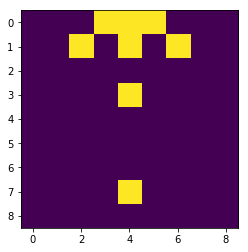

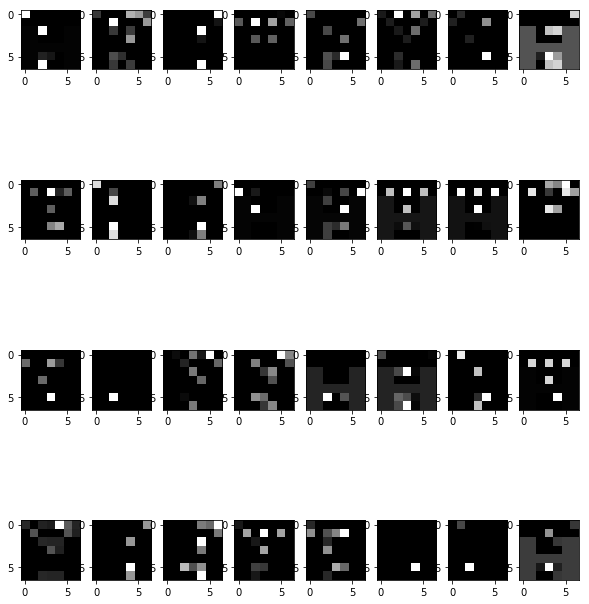

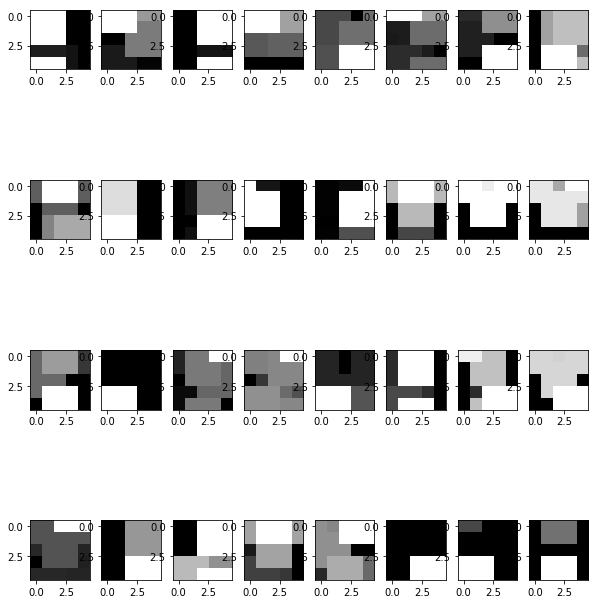

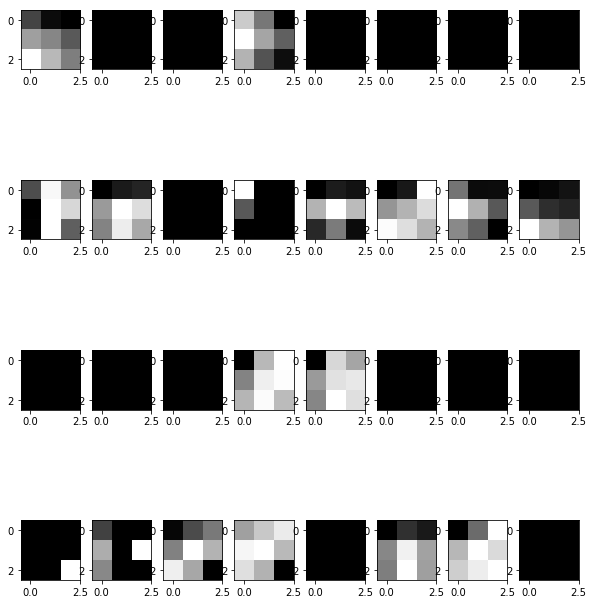

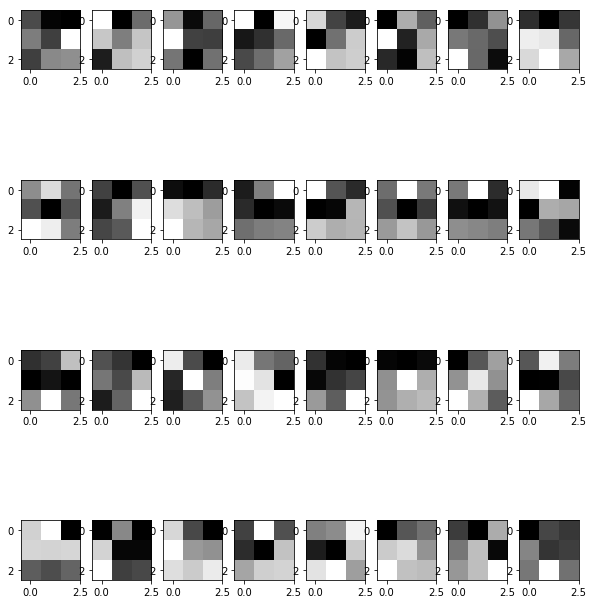

In [0]:
genNew=False
visCNN=3  # visualize the activation
num_can=8

L=9
pos=4.5
num_thre=4


num_par=4
num_stats=4

isSeries=True
buffer=0
image_height=5.1

data_params=buffer, num_stats,num_par, isSeries
common_params=L, num_thre #, T_thres
image_params=num_can, num_thre, image_height
num=num_par+num_stats

#plotRankCNN(L,dirDatas,thre_plot=2,modeCNN=1,buffer=0,isSeries=True,num_thre=4,image_height=5)
datasets,common_params=splitData(dirDatas,data_params, common_params)
L,num_thre,T_thres=common_params
    
axs_series=None
common_params=L,num_thre,T_thres
x_test1,order1,bench=plotRankCNN_loop(datasets,axs_series,common_params,image_params,visCNN,genNew,plotLinear=False)

(4,)


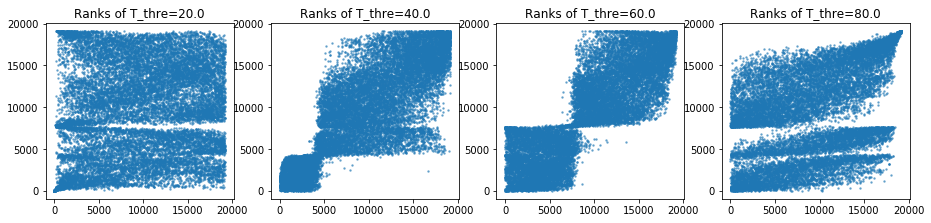

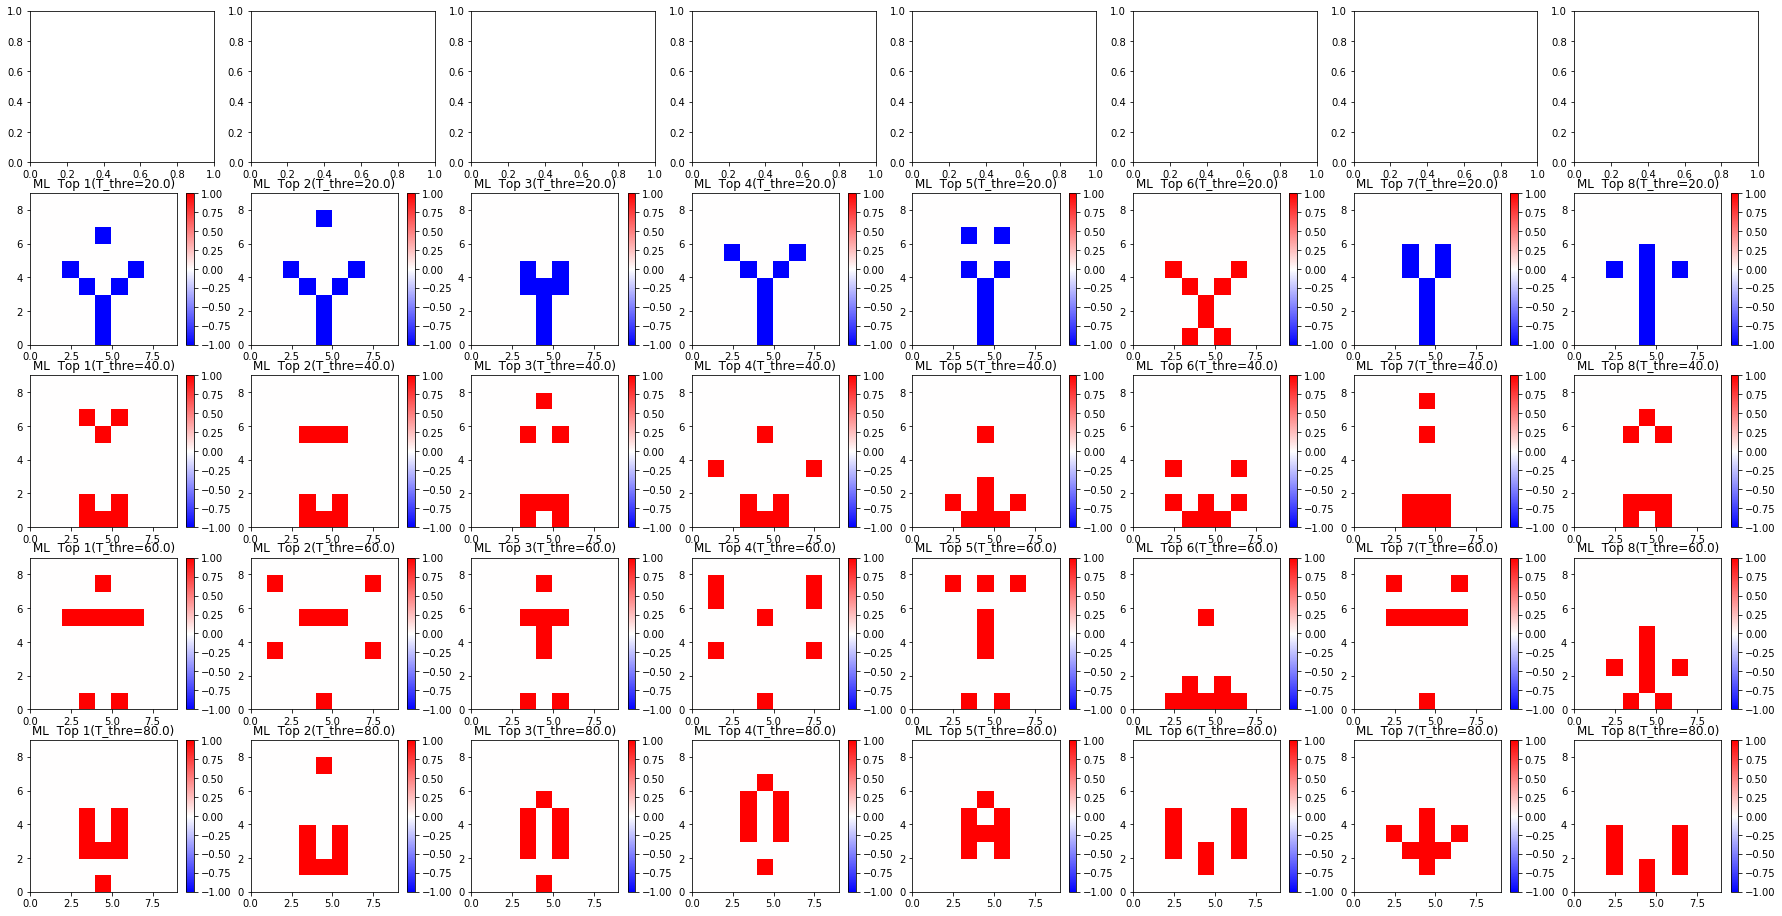

In [0]:
genNew=False
num_can=8


visCNN=1
L=9
pos=4.5
num_thre=4


num_par=4
num_stats=4

isSeries=True
buffer=0
image_height=5.1

data_params=buffer, num_stats,num_par, isSeries
common_params=L, num_thre #, T_thres
image_params=num_can, num_thre, image_height
num=num_par+num_stats

#plotRankCNN(L,dirDatas,thre_plot=2,modeCNN=1,buffer=0,isSeries=True,num_thre=4,image_height=5)
if genNew:
    datasets,common_params=splitData(dirDatas,data_params, common_params)
    L,num_thre,T_thres=common_params
    
axs_series=initializeMLPlots(image_params)
axs,axs2=axs_series
print(axs.shape)
common_params=L,num_thre,T_thres
x_test1,order1,bench=plotRankCNN_loop(datasets,axs_series,common_params,image_params,visCNN,genNew,plotLinear=False)

Max Temperature Increase is 83.19715961469741
Min Temperature Increase 10.638390526961125
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_93 (Conv2D)           (None, 7, 7, 32)          320       
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 3, 3, 64)          18496     
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_61 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_122 (Dense)            (None, 64)                4160      
_____________________________

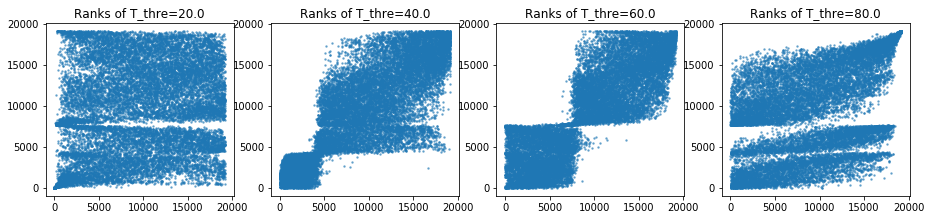

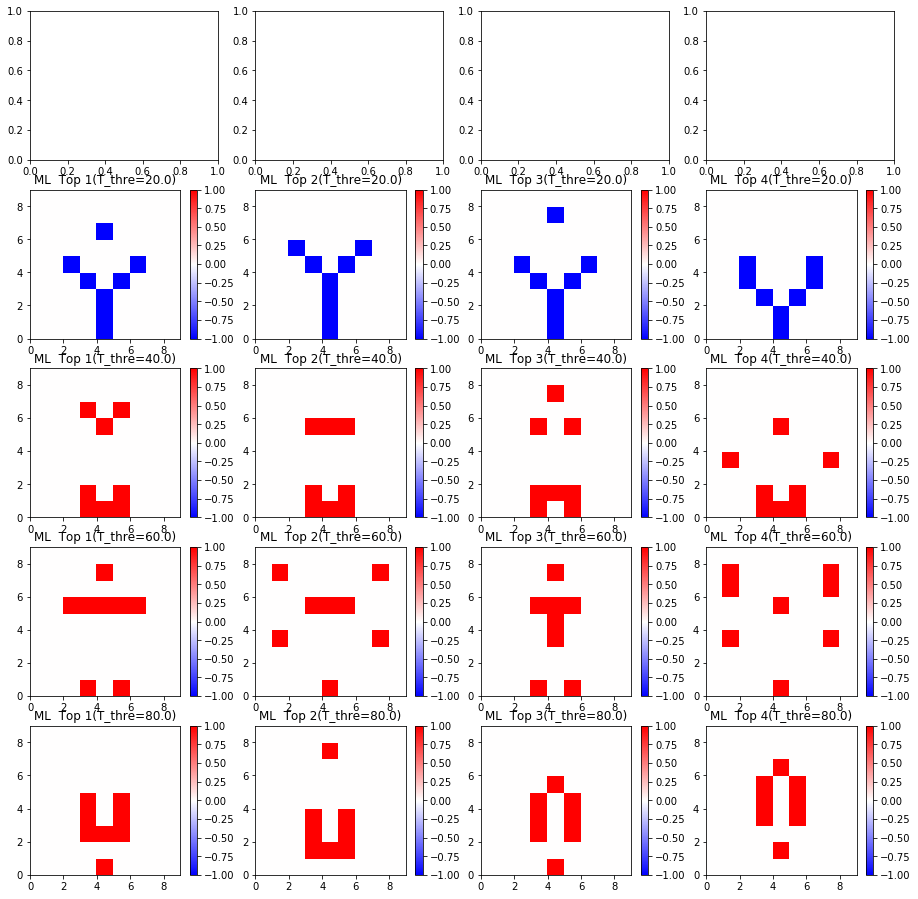

In [0]:
genNew=True
visCNN=1
L=9
pos=4.5
num_thre=4
num_can=4

num_par=4
num_stats=4

isSeries=True
buffer=0
image_height=5

data_params=buffer, num_stats,num_par, isSeries
common_params=L, num_thre #, T_thres
image_params=num_can, num_thre, image_height
num=num_par+num_stats

dirData1=(root_folder+"data/L9/Records_mesh_1_sideLoop_1000_total_L_9_num_8_mid_2_side_3_pad_1_.mat")
dirData2=(root_folder+"data/L9/Records_mesh_1_sideLoop_1024_total_L_9_num_8_mid_2_side_3_pad_1_.mat")
dirData3=(root_folder+"data/L9/Records_mesh_1_sideLoop_276_c_L_9_num_8_mid_4_side_2_pad_1_.mat")
dirData4=(root_folder+"data/L9/Records_mesh_1_sideLoop_24_c_L_9_num_8_mid_6_side_1_pad_1_.mat")
dirData5=(root_folder+"data/L9/Records_mesh_1_sideLoop_10626_c_L_9_num_8_mid_0_side_4_pad_1_.mat")

dirDatas=(dirData1,dirData2,dirData3,dirData4)

#plotRankCNN(L,dirDatas,thre_plot=2,modeCNN=1,buffer=0,isSeries=True,num_thre=4,image_height=5)
if genNew:
    datasets,common_params=splitData(dirDatas,data_params, common_params)
    L,num_thre,T_thres=common_params
    axs_series=initializeMLPlots(image_params)
x_test1,order1,bench=plotRankCNN_loop(datasets,axs_series,common_params,image_params,visCNN,genNew,plotLinear=False)

Max Temperature Increase is 83.19715961469741
Min Temperature Increase 10.638390526961125


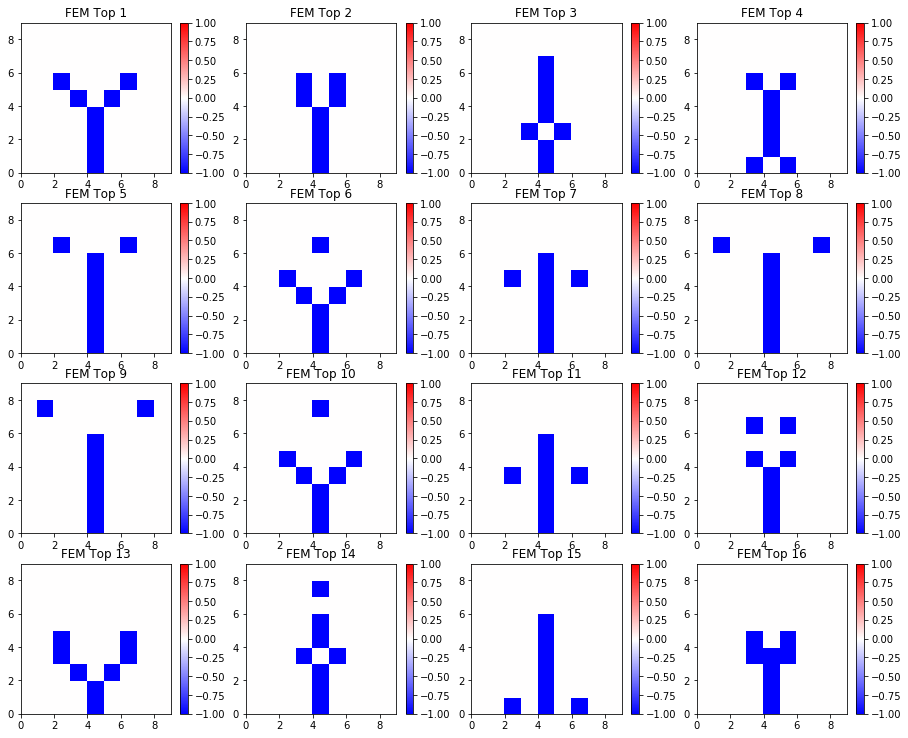

In [0]:
genNew=True
visCNN=1
L=9
pos=4.5
num_thre=4
num_can=4

num_par=4
num_stats=4

isSeries=True
buffer=0
image_height=5

data_params=buffer, num_stats,num_par, isSeries
common_params=L, num_thre #, T_thres
image_params=num_can, num_thre, image_height
num=num_par+num_stats
dirData1=(root_folder+"data/L9/Records_mesh_1_sideLoop_1000_total_L_9_num_8_mid_2_side_3_pad_1_.mat")
dirData2=(root_folder+"data/L9/Records_mesh_1_sideLoop_1024_total_L_9_num_8_mid_2_side_3_pad_1_.mat")
dirData3=(root_folder+"data/L9/Records_mesh_1_sideLoop_276_c_L_9_num_8_mid_4_side_2_pad_1_.mat")
dirData4=(root_folder+"data/L9/Records_mesh_1_sideLoop_24_c_L_9_num_8_mid_6_side_1_pad_1_.mat")
dirData5=(root_folder+"data/L9/Records_mesh_1_sideLoop_10626_c_L_9_num_8_mid_0_side_4_pad_1_.mat")

dirDatas=(dirData1,dirData2,dirData3,dirData4)

#plotRankCNN(L,dirDatas,thre_plot=2,modeCNN=1,buffer=0,isSeries=True,num_thre=4,image_height=5)
if genNew:
    datasets,common_params=splitData(dirDatas,data_params, common_params)
    bench=plotFEM(datasets,image_params)

In [0]:
L=9
pos=4.5
num_can=4
num_par=4
num_stats=4
num=num_par+num_stats
dirData1=(root_folder+"data/L9/Records_mesh_1_sideLoop_1000_total_L_9_num_8_mid_2_side_3_pad_1_.mat")
dirData2=(root_folder+"data/L9/Records_mesh_1_sideLoop_1024_total_L_9_num_8_mid_2_side_3_pad_1_.mat")
dirData3=(root_folder+"data/L9/Records_mesh_1_sideLoop_276_c_L_9_num_8_mid_4_side_2_pad_1_.mat")
dirData4=(root_folder+"data/L9/Records_mesh_1_sideLoop_24_c_L_9_num_8_mid_6_side_1_pad_1_.mat")
dirData5=(root_folder+"data/L9/Records_mesh_1_sideLoop_10626_c_L_9_num_8_mid_0_side_4_pad_1_.mat")

dirDatas=(dirData1,dirData2,dirData3,dirData4)

plotRankCNN(L,dirDatas,thre_plot=2,buffer=0,isSeries=True,num_thre=4,image_height=5)

In [0]:
L=9
pos=4.5
num_can=4
num_par=4
num_stats=4
num=num_par+num_stats
dirData1=(root_folder+"data/L9/Records_mesh_1_sideLoop_1000_total_L_9_num_8_mid_2_side_3_pad_1_.mat")
dirData2=(root_folder+"data/L9/Records_mesh_1_sideLoop_1024_total_L_9_num_8_mid_2_side_3_pad_1_.mat")
dirData3=(root_folder+"data/L9/Records_mesh_1_sideLoop_276_c_L_9_num_8_mid_4_side_2_pad_1_.mat")
dirData4=(root_folder+"data/L9/Records_mesh_1_sideLoop_24_c_L_9_num_8_mid_6_side_1_pad_1_.mat")
dirData5=(root_folder+"data/L9/Records_mesh_1_sideLoop_10626_c_L_9_num_8_mid_0_side_4_pad_1_.mat")

dirDatas=(dirData1,dirData2,dirData3,dirData4)

plotRankCNN(L,dirDatas,thre_plot=3,buffer=0,isSeries=True,num_thre=4,image_height=5)

In [0]:
metrics = {'accuracy': accuracy}
tf.summary.scalar('accuracy', accuracy[1])

if mode == tf.estimator.ModeKeys.EVAL:
    return tf.estimator.EstimatorSpec(
        mode, loss=loss, eval_metric_ops=metrics)

NameError: ignored

In [0]:
def plotRankCNN(L,dirDatas,thre_plot,modeCNN=1,buffer=0,isSeries=False,num_thre=4,image_height=5):
  num_par=4
  num_stats=4
  num=num_par+num_stats
  k_num=1
  class_names=['cooled','heated']
  if isSeries:
    geo, maxT=readXYseries(dirDatas,L,num_par,num)
  else:
    geo, maxT=readXY(dirDatas,L,num_par,num)
  T_thres=getTthre(maxT,num_thre,buffer)
  
  k_num=1
  k=0
  i=thre_plot
  cols=4
  rows=int(k_num*num_thre/cols)
  fig,axs=initFig(k_num,num_thre,rows,cols,image_height)
  class_names=['cooled','heated']

  x_train1, x_test1, y_train1, y_test1 = train_test_split(geo, maxT, test_size=0.25, random_state=0)

  T_thre=T_thres[i]
  y_train=np.where(y_train1 > T_thre, 1, 0)
  y_test=np.where(y_test1 > T_thre, 1, 0)
  train_test_set=x_train1,y_train,x_test1,y_test,y_test1
  seq=1*(k*num_thre+i)
  if modeCNN==1:
    CNN_simple_rank(train_test_set,axs,seq,L,T_thre,plotProcess=True)
  else:
    CNN_Estimator_rank(train_test_set,axs,seq,L,T_thre,plotProcess=True)





def CNN_Estimator_rank(train_test_set,axs,seq,L,T_thre,plotProcess):
    x_train,y_train,x_test,y_test,y_test1=train_test_set
    # all parameters not specified are set to their defaults
    #print(x_train.shape)
    #x_train.reshape(-1,L,L)
    #print(x_train.shape)
    model_dirs="/tmp/ht_cnn_model_"+str(L)+"_Thre_"+str(T_thre)
    # Create the Estimator
    ht_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/tmp/ht_cnn_model_"+str(L)+"_Thre_"+str(T_thre))

    # Set up logging for predictions
    tensors_to_log = {"probabilities": "softmax_tensor"}

    logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

    # Train the model
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_train},
    y=y_train,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

    # train one step and display the probabilties
    ht_classifier.train(input_fn=train_input_fn, steps=1000)
    #if plotProcess:
      #tensorboard --logdir=model_dirs
    
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_test},
    y=y_test,
    num_epochs=1,
    shuffle=False)

    eval_results = ht_classifier.evaluate(input_fn=eval_input_fn)
    print(eval_results)
    

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models

tf.logging.set_verbosity(tf.logging.INFO)

def cnn_model_fn(features, labels, mode,params):
  L=9
  fcUnit=L*L
  """Model function for CNN."""
  # Input Layer
  input_layer = tf.reshape(features["x"], [-1, L, L, 1])

  # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)
  # producing a layer of (L-2)*(L-2)
  #padded into L*L
  # Pooling Layer #1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[3, 3], strides=2)
  # producing (L-2-3)/2


  # Dense Layer
  pool2_flat = tf.reshape(pool1, [-1, int((L-3)/2+1) * int((L-3)/2+1) * 32])
  dense = tf.layers.dense(inputs=pool2_flat, units=fcUnit, activation=tf.nn.relu)
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits Layer
  logits = tf.layers.dense(inputs=dropout, units=2)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])
  }
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)